In [10]:
import sys
import os

sys.path.append("pathto/utils")

import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np 
import random 
import pandas as pd
import crossregion
import seaborn as sns
# import loadData
# fix random seed
np.random.seed(1234)
random.seed(1234)

In [11]:
#load all clustered adatas from folder 
data_dir = "/home/share/ST_mouse/HIP_1014/HIP_mouse/clus/mouse1_new"
adatas = {} 
for i in os.listdir(data_dir):
    adatas[i[:i.find(".")]] = sc.read_h5ad(os.path.join(data_dir, i))

In [12]:
adata = crossregion.merge(adatas) 
adata.write("./mouse.h5ad")

/home/feity/.conda/envs/tf/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [13]:
# normalize all 
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata) 

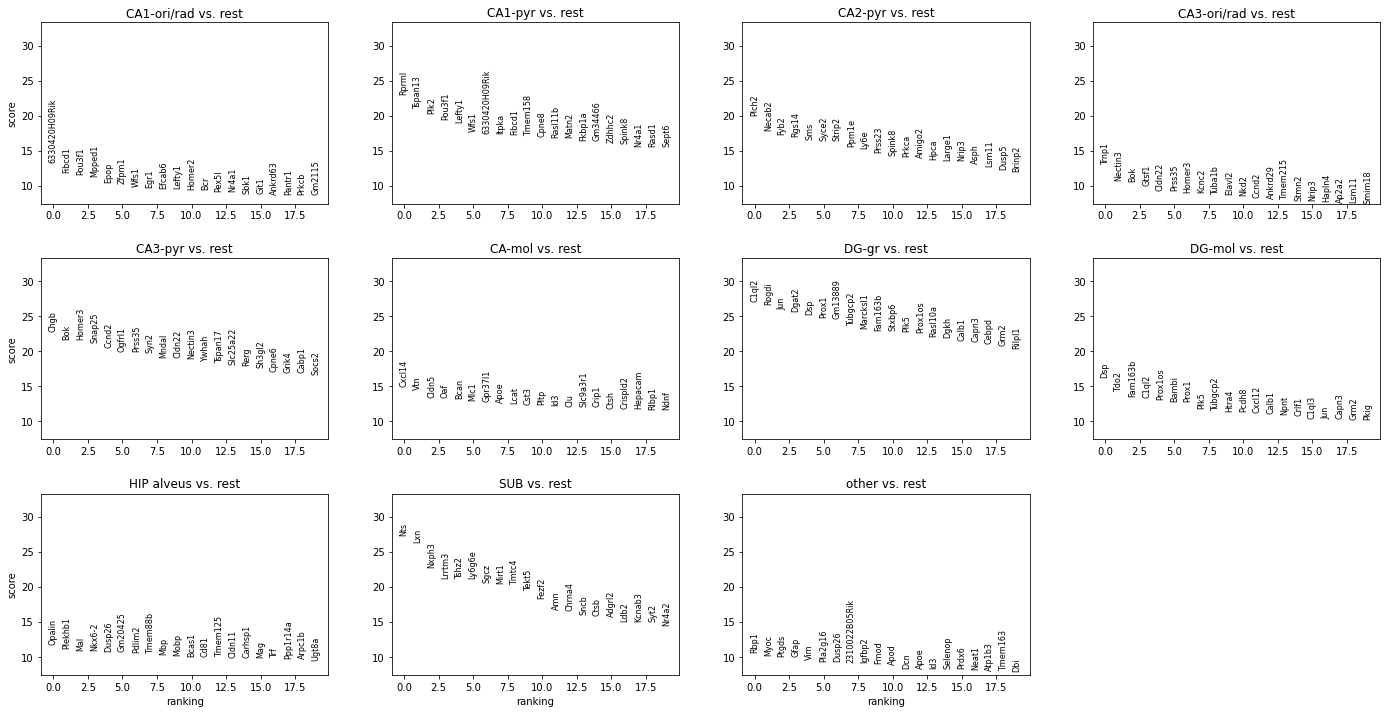

In [14]:
# call marker genes for a subregion
sc.tl.rank_genes_groups(
    adata, groupby="mapped", method="t-test", use_raw=False
)
sc.pl.rank_genes_groups(adata)

In [44]:
# call marker gene for each chip and test 
for i in adatas:
    adata = adatas[i]
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata)
    sc.tl.rank_genes_groups(
    adata, groupby="mapped", method="t-test", use_raw=False
    )

In [73]:
regions= []
genes = [] 
for i in adatas:
    adata = adatas[i]
    for j in adata.uns["rank_genes_groups"]["names"].dtype.names:
        if j == "other":
            continue
        regions.append("%s_%s"%(i, j))
        genes.append(adata.uns["rank_genes_groups"]["names"][j][:200])

In [74]:
#calculate jaccard similarity for each subregion on each chip
res = np.zeros((len(regions), len(regions)))
for i in range(len(regions)):
    for j in range(len(regions)):
        res[i][j] = crossregion.Jaccard(genes[i], genes[j])

/home/feity/.conda/envs/tf/lib/python3.7/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


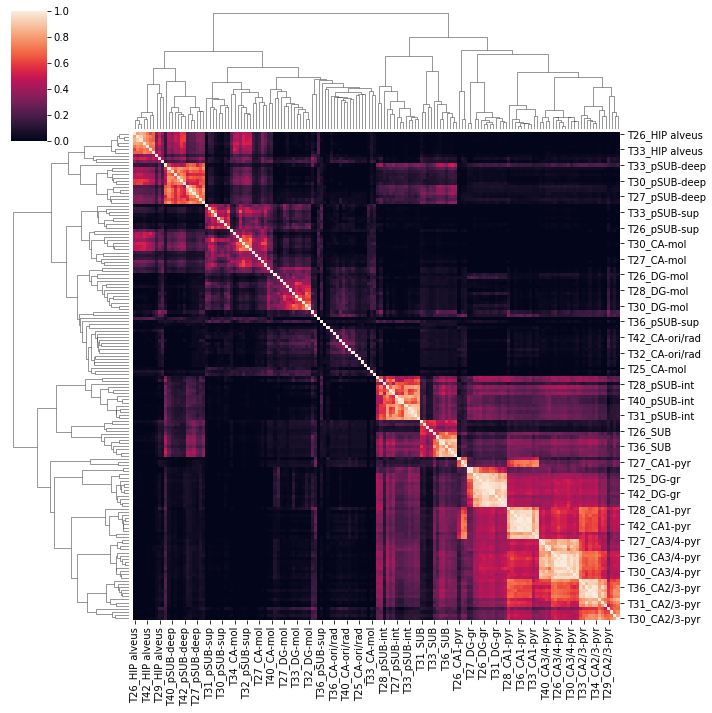

In [75]:
sns.clustermap(pd.DataFrame(res, columns=regions, index=regions))

In [2]:
#cross species subregion comparison
mouse = sc.read_h5ad("./mouse.h5ad")
marmoset = sc.read_h5ad("./marmoset.h5ad")
macaque = sc.read_h5ad("./macaque.h5ad")
mouse = crossregion.mergeSingleAdata(mouse) 
marmoset = crossregion.mergeSingleAdata(marmoset)
macaque = crossregion.mergeSingleAdata(macaque)

/home/feity/.conda/envs/tf/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
#normalize data
sc.pp.normalize_total(mouse, target_sum=1e6)
sc.pp.normalize_total(macaque, target_sum=1e6)
sc.pp.normalize_total(marmoset, target_sum=1e6)
sc.pp.log1p(mouse)
sc.pp.log1p(macaque)
sc.pp.log1p(marmoset)

In [4]:
# pickout genes from three species
sc.pp.highly_variable_genes(mouse, n_top_genes=5000)
sc.pp.highly_variable_genes(macaque, n_top_genes=5000)
sc.pp.highly_variable_genes(marmoset, n_top_genes=5000)
mouse = mouse[:, mouse.var["highly_variable"]]
macaque = macaque[:, macaque.var["highly_variable"]]
marmoset = marmoset[:, marmoset.var["highly_variable"]]
mouse.var.index = [i.upper() for i in mouse.var.index]

In [5]:
a = np.intersect1d(marmoset.var_names, macaque.var_names)
genes = np.intersect1d(a, mouse.var_names)
len(genes), genes[:10]

(1599,
 array(['A2M', 'A2ML1', 'ABCA1', 'ABCA2', 'ABI1', 'ABLIM3', 'ABRACL',
        'ABTB2', 'ACBD7', 'ACSBG1'], dtype=object))

In [7]:
#calculate pearson correlation between subregions accross species
from scipy import stats
macaque = macaque[:, genes]
marmoset = marmoset[:, genes] 
a = macaque.obs.index
b = marmoset.obs.index 
res = np.zeros((len(macaque),  len(marmoset)))
for i in range(len(a)):
    for j in range(len(b)):
        res[i][j] = stats.pearsonr(macaque.X[i], marmoset.X[j])[0]

<AxesSubplot:xlabel='idx', ylabel='idx'>

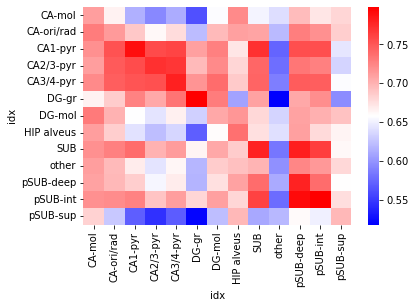

In [9]:
sns.heatmap(pd.DataFrame(res, columns=b, index=a), cmap="bwr")